# 第八次作业

In [1]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt

**4.17** Simulate the motion of asteroids near the one of the Kirkwood gaps. The 2/1 and 7/3 gaps are good choices.

__解__: 由开普勒第三定律, 周期$T$和半长轴$a$有关系 $T^2/a^3$ 为常数, 则有$$\frac{a_1}{a_2}=(\frac{T_1}{T_2})^{{2}/{3}}\ ,$$带入木星公转周期$T_J$与小行星公转周期$T_A$比值 $2/1$ 和 $7/3$以及木星轨道半径 $a_J = 5.20\ \text{AU},$ 得$$\begin{aligned}a_A = 0.6300a_J = 3.276\ \text{AU},\quad &T_J/T_A=1/2,\\a_A = 0.5684a_J=2.957\ \text{AU},\quad &T_J/T_A=3/7. \end{aligned}$$

在计算中假设太阳是静止的, 对小行星$x$方向有$$\frac{d v_{Ax}}{d t} = -\frac{G M_S x_A}{r_A^3} - \frac{G M_J (x_A-x_J)}{r_{AJ}^3}\ ,$$位置更新公式为$$x_{A, i+1} = x_{A, i}+v_{Ax, i+1}\Delta t\ ,$$ 对$y$方向以及木星有形式类似的公式(但不考虑小行星对木星的引力)。

In [38]:
class Ex4_17:
    '''Simulate the motion of asteroids near the one of the Kirkwood gaps
    '''
    GM_S = 4 * np.pi * np.pi
    GM_J = GM_S * (1.9e27/2.0e30) # 4π²M_J/M_S
    R_JUP = 5.20 # orbit radius of Jupiter, in astronomical unit
    T_JUP = 11.857 # Orbit peroid of Jupiter, in year
    
    def __init__(self, time_step=1e-3):
        '''`Kirkwood` class initialization
        Parameter
            time_step: time step of Euler-Cromer method, in year
        '''
        
        self.xy_jup = np.empty((1, 2), dtype='float64') # coordinate of Jupiter
        self.v_jup =np.empty((1, 2), dtype='float64') 
        self.xy_ast = np.empty((1, 2), dtype='float64') 
        self.v_ast = np.empty((1, 2), dtype='float64') # velocity of the asteroid
        self.t = None
        self.delta_t = time_step
        
    def calc_motion(self, coord0_jup, v0_jup, coord0_ast, v0_ast, time_span, time_step=None):
        '''calculate the motion of Jupiter and an asteroid which is affected 
        by both the Sun and Jupiter.
        
        Parameters
            coord0_jup: tuple, initial (x, y) of Jupiter
            v0_jup: tuple, initial (vx, vy) of Jupiter
            coord0_ast: tuple, initial (x, y) of the asteroid
            v0_ast: tuple, initial (vx, vy) of the asteroid
            time_span: time span of the motion, in year
            time_step: time step of this calculation, or 
                use current value if None is given
        '''
        
        if time_step is None:
            dt = self.delta_t
        else:
            self.delta_t = dt = time_step
        self.__init__(self.delta_t)
        self.xy_jup[-1] = coord0_jup
        self.v_jup[-1] = v0_jup
        self.xy_ast[-1] = coord0_ast
        self.v_ast[-1] = v0_ast
        self.t = [0.0]
        
        eucli = distance.euclidean
        while self.t[-1] < time_span:
            vi1_ast = self.v_ast[-1] - dt * (
                self.GM_S * self.xy_ast[-1] / eucli(self.xy_ast[-1], (0,0))**3 +
                self.GM_J * (self.xy_ast[-1] - self.xy_jup[-1]) / eucli(self.xy_ast[-1], self.xy_jup[-1])**3
            )
            vi1_ast = vi1_ast[np.newaxis, ]
            vi1_jup = self.v_jup[-1] - self.GM_S * self.xy_jup[-1] / eucli(self.xy_jup[-1], (0,0))**3 * dt
            vi1_jup = vi1_jup[np.newaxis, ]
            self.xy_ast = np.r_[self.xy_ast, self.xy_ast[-1] + vi1_ast * dt]
            self.xy_jup = np.r_[self.xy_jup, self.xy_jup[-1] + vi1_jup * dt]
            self.v_ast = np.r_[self.v_ast, vi1_ast]
            self.v_jup = np.r_[self.v_jup, vi1_jup]
            self.t.append(self.t[-1] + dt)
    
    def kirkwood_simulation(self, T_jup, T_ast, v0_jup=None, v0_ast=None):
        '''calculate the motion of the asteroid in Kirkwood gap T_jup/T_ast
        '''
        if v0_jup is None:
            v0_j = 2.755
        else:
            v0_j = v0_jup
        ra_over_rj = np.power(T_ast/T_jup, 2/3) # radius of asteroid divide radius of Jupiter
        if v0_ast is None:
            v0_a = v0_j * np.sqrt(ra_over_rj)
        else:
            v0_a = v0_ast
        
        self.calc_motion(
            coord0_jup=(self.R_JUP, 0.0),
            v0_jup=(0.0, v0_j),
            coord0_ast=(ra_over_rj * self.R_JUP, 0.0),
            v0_ast=(0.0, v0_a),
            time_span=5 * T_ast/T_jup * self.T_JUP
        )
    
    @staticmethod
    def calc_eccentricity(X, Y):
        '''calculate eccentricity of an orbit (X, Y), assume that
        the majoraxis is placed along either x-axis or y-axis
        '''
        a = max(X[:].max(), Y[:].max())
        b = min(X[:].max(), Y[:].max())
        c = np.sqrt(a**2-b**2)
        return c/a
    
    @staticmethod
    def plot_kirkwood(xy_ast=None, xy_jup=None, v0_a=None, title=None):
        if xy_jup is not None and xy_ast is not None:
            fig = plt.figure(figsize=(9, 4), dpi=300)
            ax = fig.add_subplot(121)
            ax.plot([0], [0], 'ro', label='Sun') # sun is at the origin
            ax.scatter(xy_ast[:, 0], xy_ast[:, 1], s=0.01, label='Asteroid')
            ax.set_xlabel('x (AU)')
            ax.set_ylabel('y (AU)')
            ax.legend(loc='upper right')
            ax.grid(True)
            ax.axis('scaled')
            ax.set_xlim(np.min(xy_ast[:, 0])-0.1, np.max(k.xy_ast[:, 0])+0.1)
            ax.set_ylim(np.min(xy_ast[:, 1])-0.1, np.max(k.xy_ast[:, 1])+0.1)
            ax = fig.add_subplot(122)
            ax.plot([0], [0], 'ro', label='Sun') # sun is at the origin
            ax.scatter(xy_ast[:, 0], xy_ast[:, 1], s=0.01, label='Asteroid')
            ax.scatter(xy_jup[:, 0], xy_jup[:, 1], s=0.01, label='Jupiter')
            ax.set_xlabel('x (AU)')
            ax.legend(loc='upper right')
            ax.grid(True)
            ax.axis('scaled')
            if v0_a is None:
                fig.suptitle(title)
            else:
                fig.suptitle(title + ', $v_{0,A}= %g$' % v0_a)
        elif xy_jup is None and xy_ast is not None:
            fig = plt.figure(figsize=(6, 6), dpi=300)
            ax = fig.add_subplot(111)
            ax.plot([0], [0], 'ro', label='Sun') # sun is at the origin
            ax.scatter(xy_ast[:, 0], xy_ast[:, 1], s=0.01, label='Asteroid')
            ax.set_xlabel('x (AU)')
            ax.set_ylabel('y (AU)')
            ax.legend(loc='upper right')
            ax.grid(True)
            ax.axis('equal')
            if v0_a is None:
                ax.set_title(title)
            else:
                ax.set_title(title + ', $v_{0,A}= %g$' % v0_a)
        return ax, fig
        

In [4]:
k = Ex4_17(0.005)

模拟 2/1 Kirkwood gap的情况

In [5]:
# k.kirkwood_simulation(2, 1)
k.calc_motion(coord0_jup=(5.2, 0), v0_jup=(0, 2.755), coord0_ast=(0, -3.276), v0_ast=(3.471, 0), time_span=30)

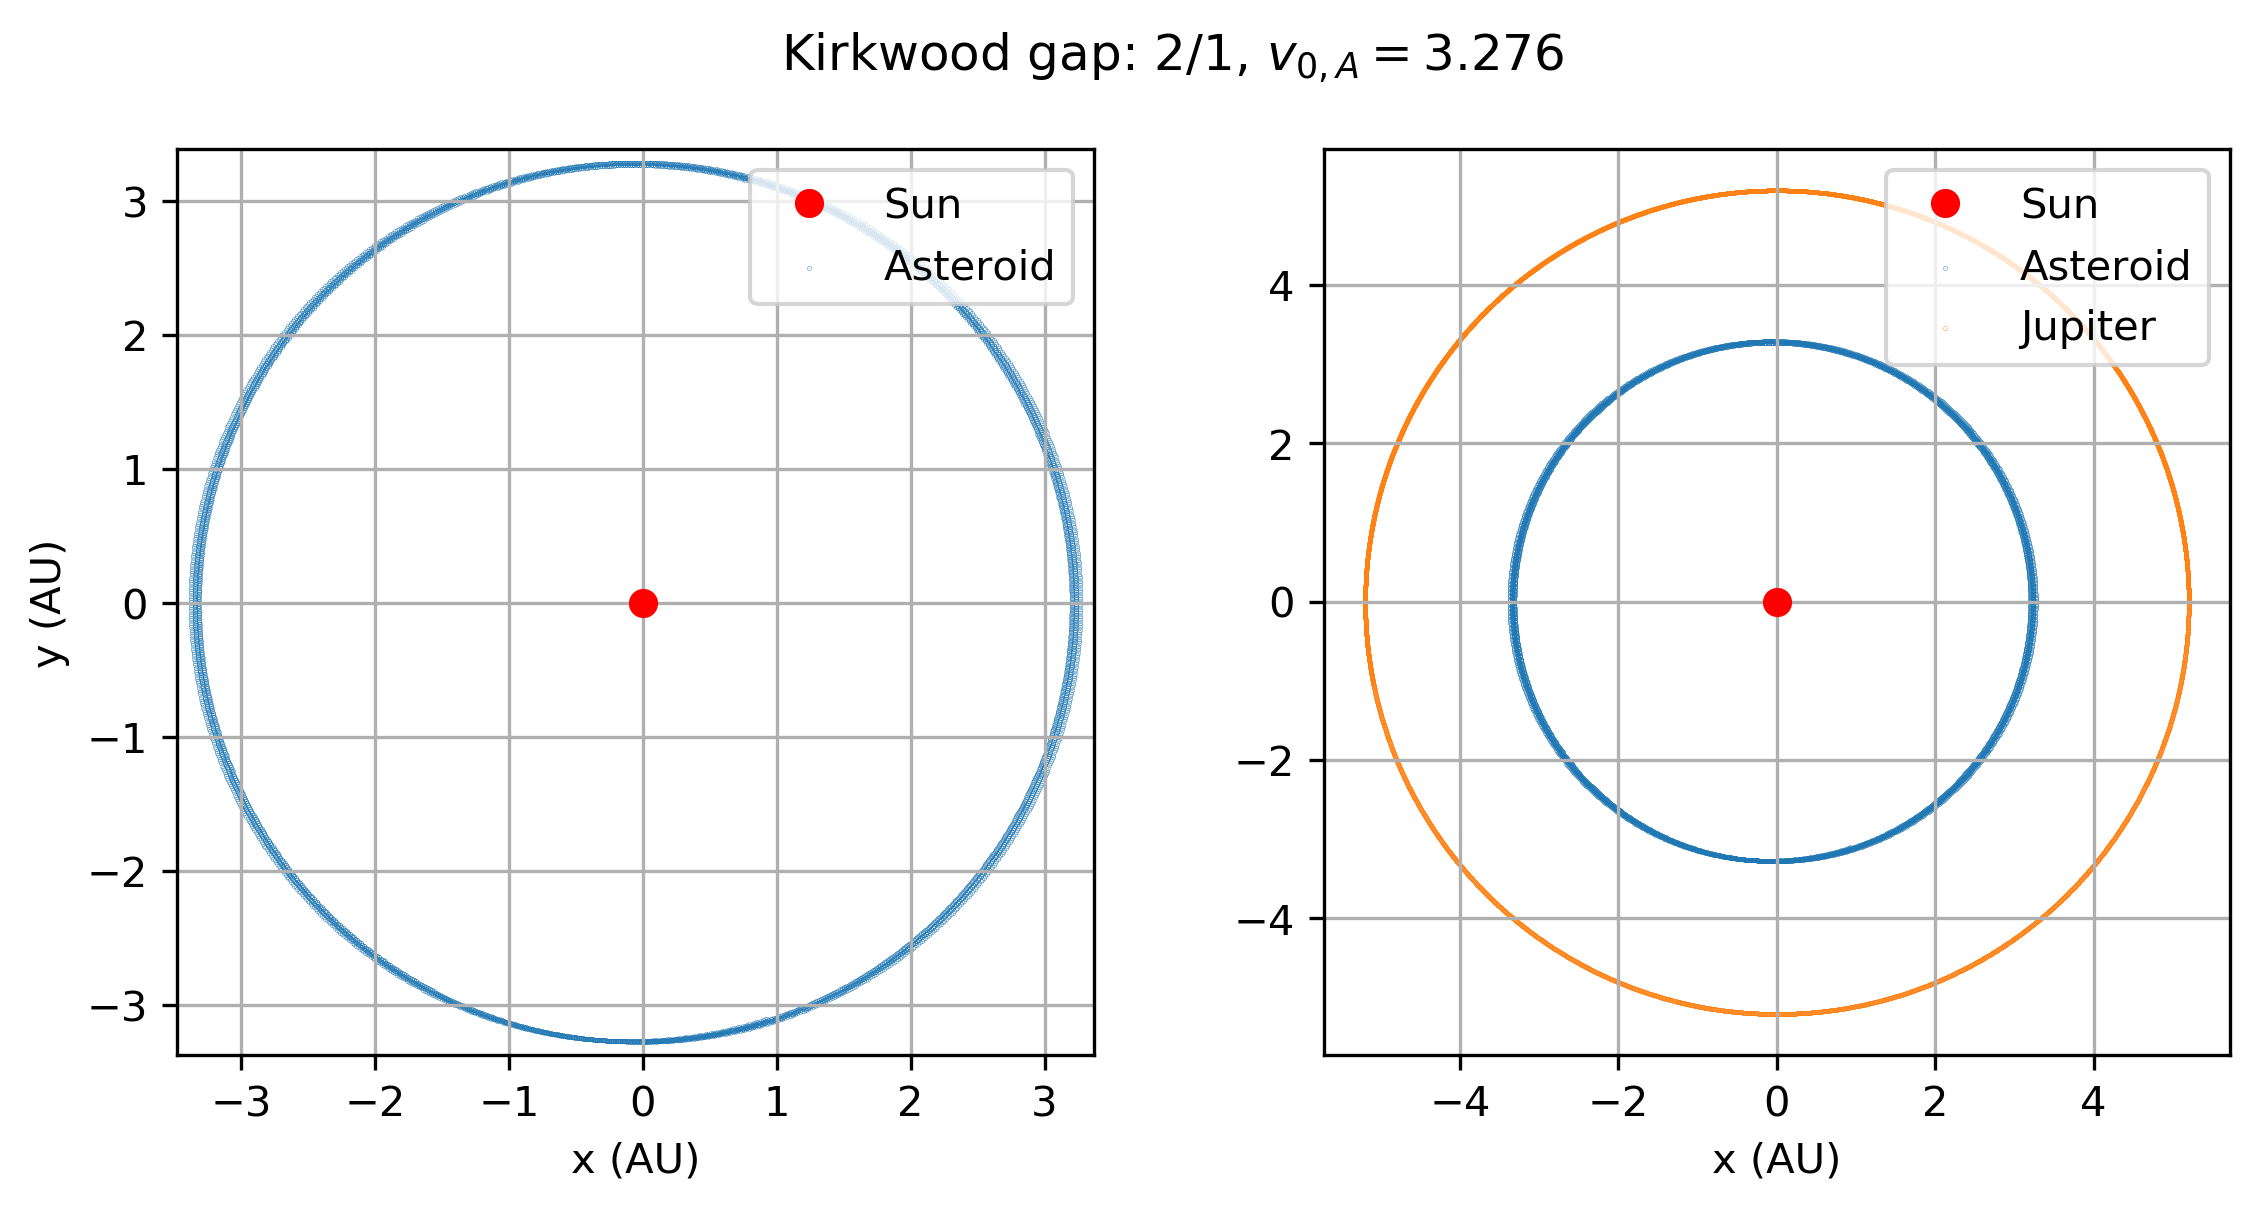

In [6]:
fig = plt.figure(figsize=(9, 4), dpi=300)
ax = fig.add_subplot(121)
ax.plot([0], [0], 'ro', label='Sun') # sun is at the origin
ax.scatter(k.xy_ast[:, 0], k.xy_ast[:, 1], s=0.01, label='Asteroid')
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.legend(loc='upper right')
ax.grid(True)
ax.axis('scaled')
ax.set_xlim(np.min(k.xy_ast[:, 0])-0.1, np.max(k.xy_ast[:, 0])+0.1)
ax.set_ylim(np.min(k.xy_ast[:, 1])-0.1, np.max(k.xy_ast[:, 1])+0.1)
# ax.set_title('Kirkwood gap: 2/1, $v_{0,A}= %g$' % 3.276)
ax = fig.add_subplot(122)
ax.plot([0], [0], 'ro', label='Sun') # sun is at the origin
ax.scatter(k.xy_ast[:, 0], k.xy_ast[:, 1], s=0.01, label='Asteroid')
ax.scatter(k.xy_jup[:, 0], k.xy_jup[:, 1], s=0.01, label='Jupiter')
ax.set_xlabel('x (AU)')
ax.legend(loc='upper right')
ax.grid(True)
ax.axis('scaled')
fig.suptitle('Kirkwood gap: 2/1, $v_{0,A}= %g$' % 3.276)
plt.savefig('2_1.svg')
plt.show()

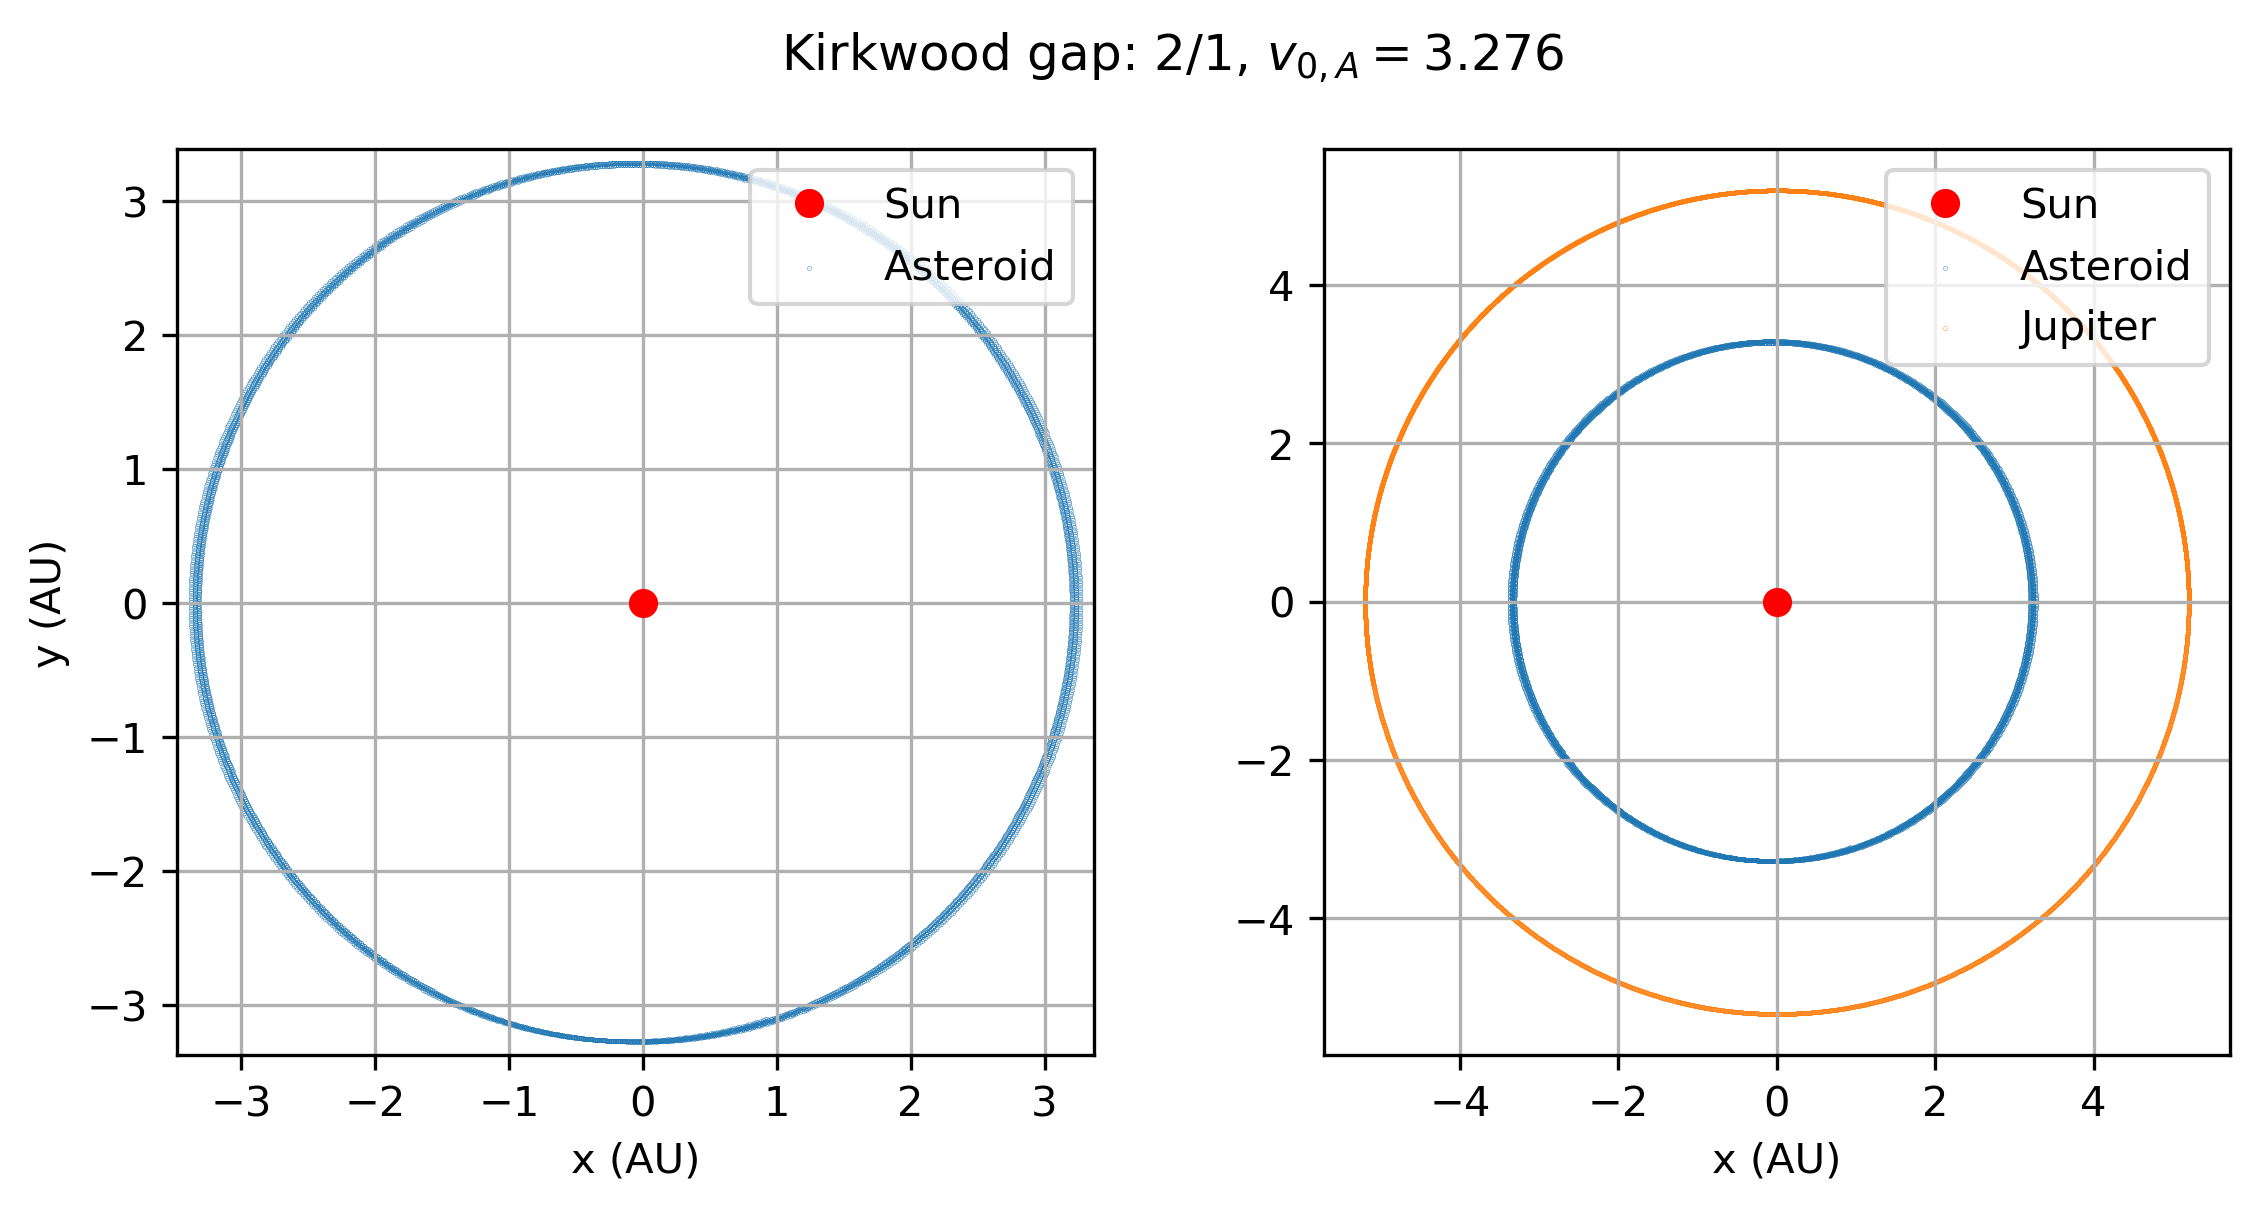

In [7]:
ax, fig = Ex4_17.plot_kirkwood(k.xy_ast, k.xy_jup, 3.276, 'Kirkwood gap: 2/1')
plt.show()

从上图可以直观的看出，当$T_J/T_A=2/1$时，小行星轨道好像被涂抹开一样，表明发生了轨道共振。

模拟 7/3 Kirkwood gap的情况

In [8]:
v0_a_est = 5.2 * np.sqrt(np.power(3/7, 2/3)) # 估计小行星初速度
print(v0_a_est)

3.9205266938716


In [12]:
possible_v0_a = []
eccen = []
for v0_a in np.arange(3.647, v0_a_est+0.5, 0.001):
    k.kirkwood_simulation(7, 3, v0_ast=v0_a)
    e = Ex4_17.calc_eccentricity(k.xy_ast[:, 0], k.xy_ast[:, 1])
    if e < 0.1:
        eccen.append(e)
        possible_v0_a.append(v0_a)
        print('e = {:.6f} when v0_ast = {:.3f}'.format(e, v0_a))
    try:
        if eccen[-1] > eccen[-6]:
            print('Growing e, break')
            break
    except IndexError:
        pass

e = 0.096587 when v0_ast = 3.657
e = 0.091060 when v0_ast = 3.658
e = 0.084849 when v0_ast = 3.659
e = 0.077825 when v0_ast = 3.660
e = 0.070235 when v0_ast = 3.661
e = 0.061616 when v0_ast = 3.662
e = 0.051480 when v0_ast = 3.663
e = 0.038976 when v0_ast = 3.664
e = 0.019275 when v0_ast = 3.665
e = 0.028000 when v0_ast = 3.666
e = 0.042423 when v0_ast = 3.667
e = 0.052769 when v0_ast = 3.668
Growing e, break


In [13]:
v0_a_best = possible_v0_a[np.argmin(eccen)]; print(v0_a_best)

3.664999999999998


In [14]:
v0_a_best = 3.665

In [15]:
k.kirkwood_simulation(7, 3, v0_ast=v0_a_best)

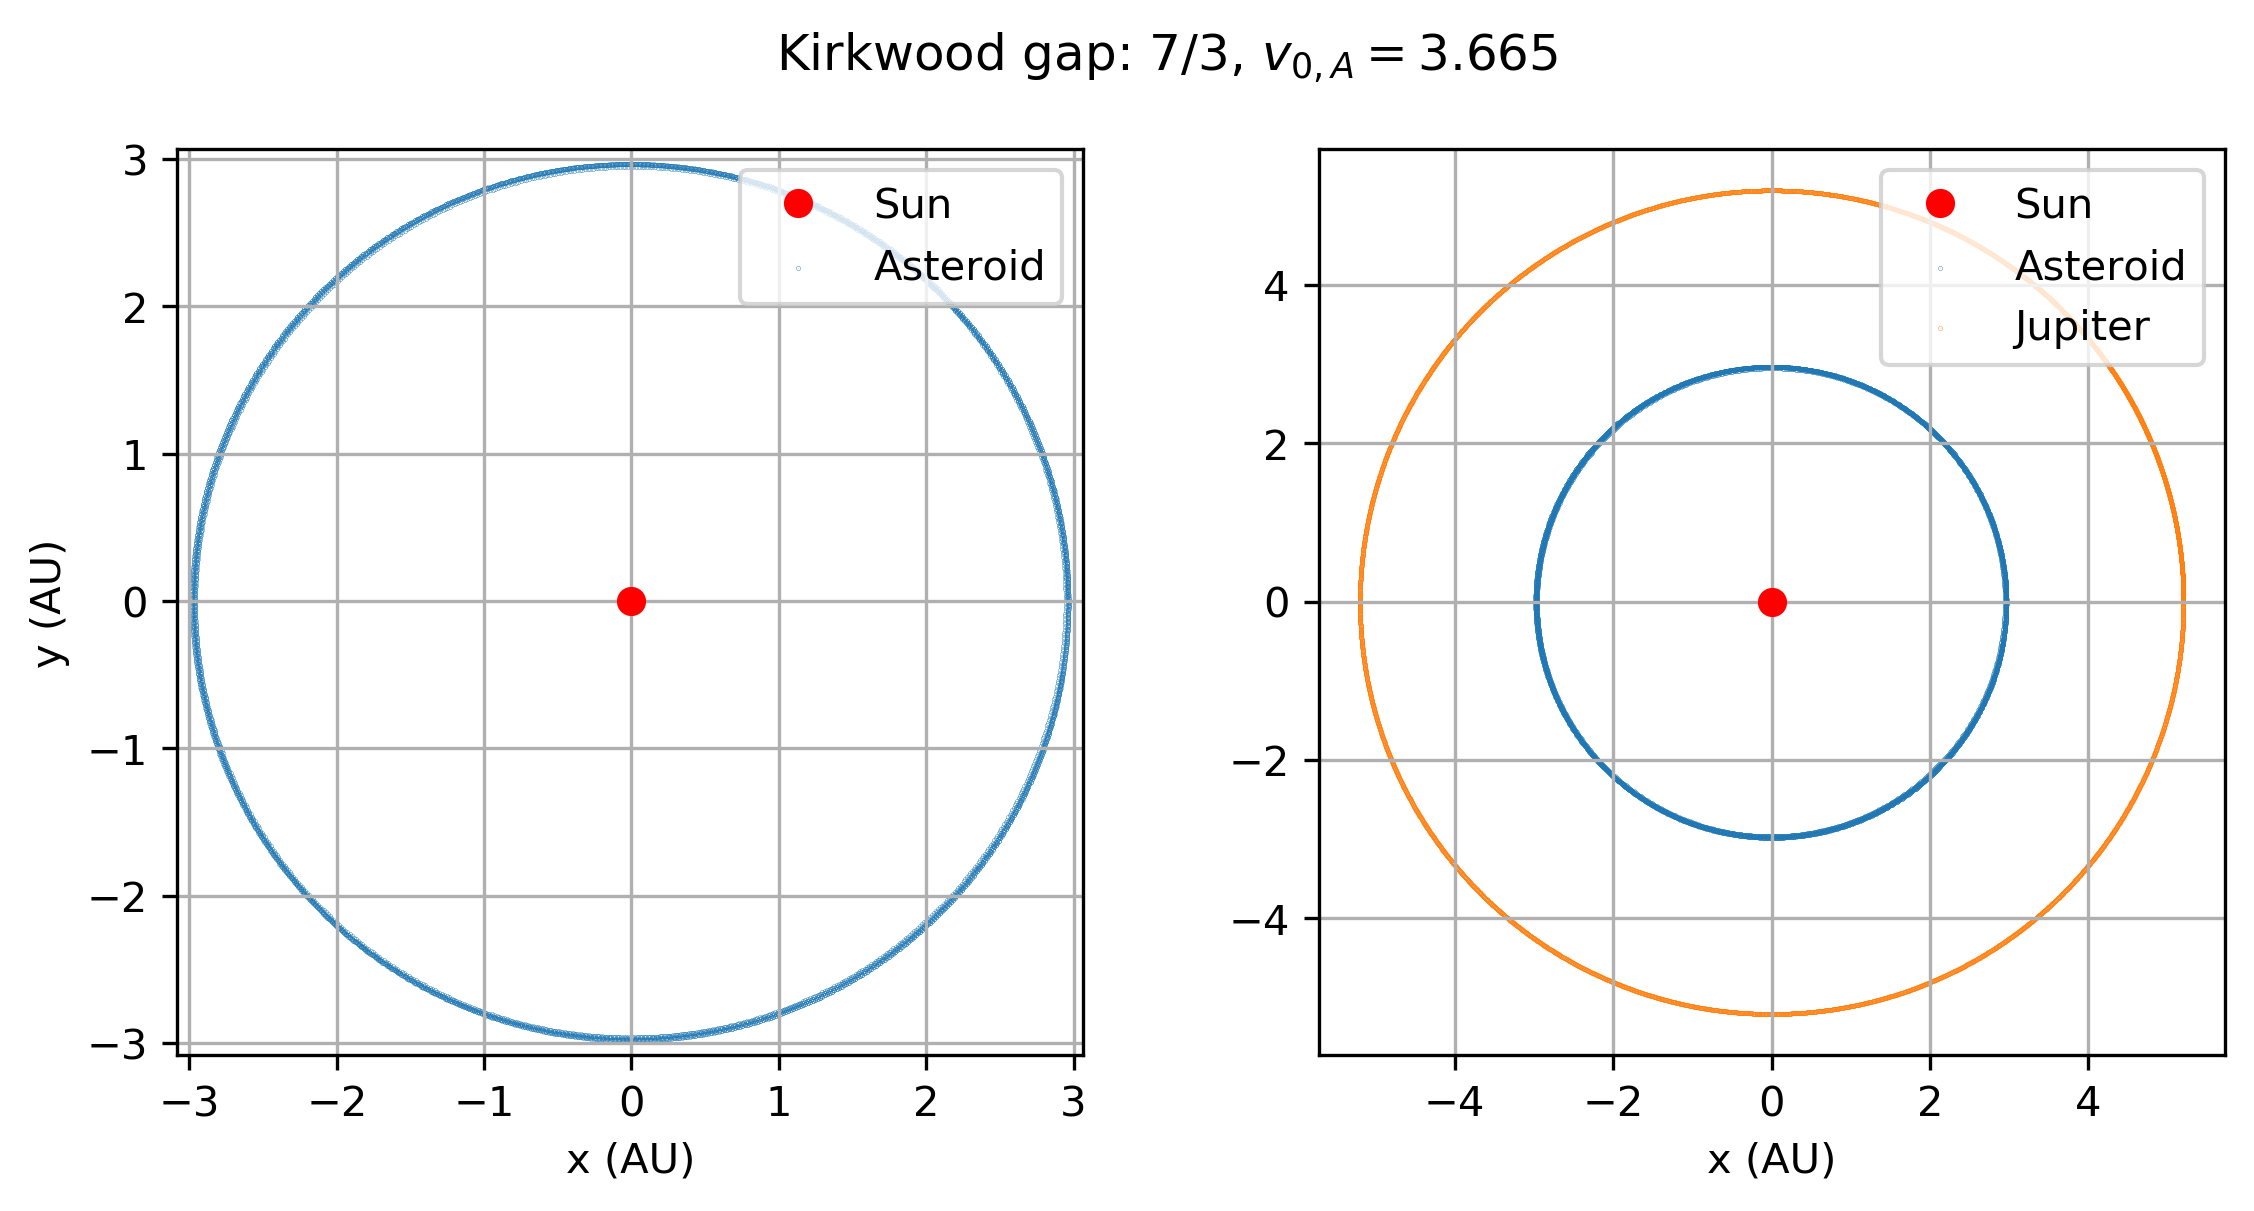

In [16]:
ax, fig = Ex4_17.plot_kirkwood(k.xy_ast, k.xy_jup, v0_a_best, "Kirkwood gap: 7/3")
plt.show()

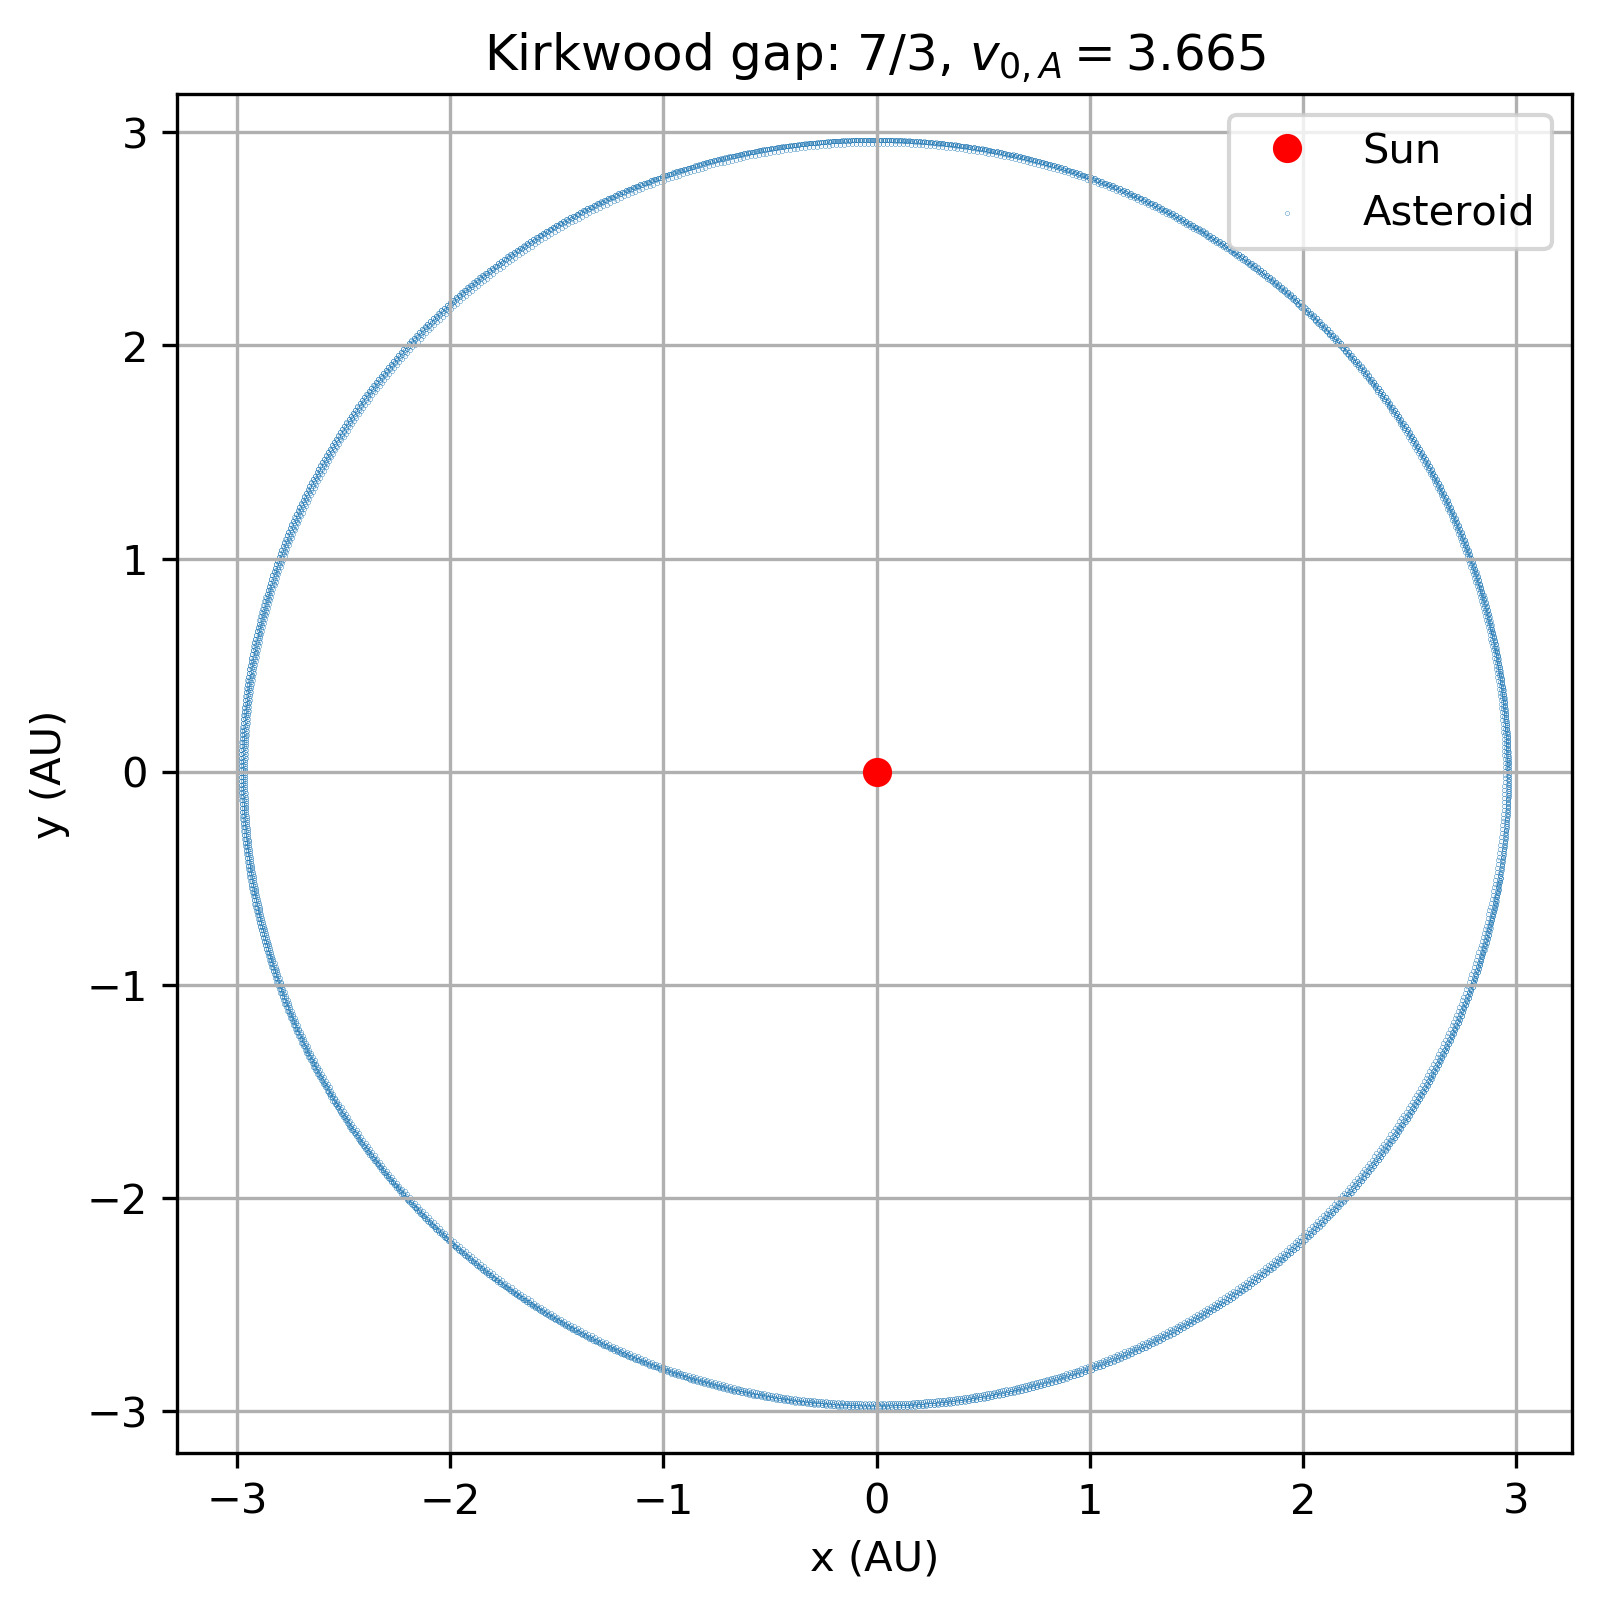

In [17]:
ax, fig = Ex4_17.plot_kirkwood(k.xy_ast, None, v0_a_best, "Kirkwood gap: 7/3")
plt.show()

可以看出，在$T_J/T_A=7/3$时，选取$v_{A, 0}=3.665\ \text{AU/yr}$, 得到的轨道也有一定的"模糊"现象。

**4.19** Study the behavior of our model for Hyperion for different initial conditions. Estimate the Lyapunov exponent from calculations of $\Delta\theta$, such as those shown in Figure 4.19. Examine how this exponent varies as a function of the eccentricity of the orbit.

In [3]:
class Hyperion:
    '''a simple simulation for the motion of Hyperion
    '''
    
    def __init__(self, time_step=0.0001):
        '''
        Parameter
            time_step: time step of simultion, in "Hyperion-year"
        '''
        self.xy = np.empty((1, 2), dtype='float32') # coordinate of center of mass of Hyperion
        self.v =np.empty((1, 2), dtype='float32') # velocity of center of mass
        self.theta = None
        self.omega = None
        self.delta_t = time_step
        self.t = [0.0]
        self.delta_theta = None
        
    def calc(self, init_coord, init_v, init_theta, init_omega, time_span, time_step=None):
        '''calculate the motion of simplified, dumbbell-like Hyperion model
        
        Parameter
            init_coord: initial coordinate of Hyperion, in "Hyperion unit"
            init_v: initial velocity of the center of mass of Hyperion, in Hyperion unit/Hyperion-year
            init_theta: initial theta of the dumbbell Hyperion
            init_omega: initial angular velocity of the dumbbell-like Hyperion
            time_span : time span of the motion, in "Hyperion-year"
            time_step : time step of the Euler-Cromer method, in Hyperion-year,
                this will change `self.delta_t`; use `self.delta_t` is None is given
        '''
        
        self.__init__()
        if time_step is None:
            dt = self.delta_t
        else:
            self.delta_t = dt = time_step
        GM_Sat = 4 * np.pi * np.pi
        self.xy[0] = init_coord
        self.v[0] = init_v
        self.theta = np.copy(init_theta).astype('float32')
        self.theta = np.reshape(self.theta, (1, -1))
        self.omega = np.ones_like(self.theta) * init_omega
        self.wrapToPi(self.theta)
        while self.t[-1] < time_span:
            r_c = distance.euclidean(self.xy[-1], (0, 0)) # distance from center of mass to Saturn
            vi1 = self.v[-1] - GM_Sat * self.xy[-1] / r_c**3 * dt
            vi1 = np.reshape(vi1, (1, -1))
            self.v[-1] = vi1 # for saving memory, save one velocity only
            sintheta_i = np.sin(self.theta[-1])
            costheta_i = np.cos(self.theta[-1])
            omegai1 = self.omega[-1] - 3*GM_Sat/r_c**5 * (
                self.xy[-1, 0]*sintheta_i - self.xy[-1, 1]*costheta_i) *  (
                self.xy[-1, 0]*costheta_i + self.xy[-1, 1]*sintheta_i) * dt
            self.omega = np.r_[self.omega, omegai1[np.newaxis, ]]
            self.xy = np.r_[self.xy, self.xy[-1] + vi1 * dt]
            self.theta = np.r_[self.theta, self.wrapToPi((self.theta[-1] + omegai1 * dt)[np.newaxis, ])]
            self.t.append(self.t[-1]+dt)
    
    @staticmethod
    def wrapToPi(x):
        '''wrap radians to [-pi, pi]'''
        y = x % (2*np.pi)
        return np.where(y <= np.pi, y, y-2*np.pi)
    
    def plot_theta_omega(self):
        '''plot theta and omega
        '''
        if self.theta.shape[1] == 1 == self.omega.shape[1]:
            fig = plt.figure(figsize=(9, 4), dpi=300)
            ax = fig.add_subplot(121)
            ax.plot(self.t, self.theta[:, 0], linewidth=0.64)
            ax.set_xlabel('time (yr)')
            ax.set_xlim(0, self.t[-1]+0.1)
            ax.set_ylabel('$\\theta$ (radians)')
            ax.set_title('Hyperion  $\\theta$ versus time')
            ax = fig.add_subplot(122)
            ax.plot(self.t, self.omega[:, 0], linewidth=0.64)
            ax.set_xlabel('time (yr)')
            ax.set_xlim(0, self.t[-1]+0.1)
            ax.set_ylabel('$\\omega$ (radians/yr)')
            ax.set_title('Hyperion  $\\omega$ versus time')
            return ax, fig
        elif self.theta.shape[1] == 2 == self.omega.shape[1]:
            fig = plt.figure(figsize=(10, 9), dpi=300)
            
            ax = fig.add_subplot(221)
            ax.plot(self.t, self.theta[:, 0], linewidth=0.64)
            ax.set_xlim(0, self.t[-1]+0.1)
            ax.set_ylabel(r'$\theta$ (radians)')
            ax.set_title(r'$\theta$, $\theta_0= {:g}$'.format(self.theta[0, 0]))
            ax = fig.add_subplot(222)
            ax.plot(self.t, self.omega[:, 0], linewidth=0.64)
            ax.set_xlim(0, self.t[-1]+0.1)
            ax.set_ylabel(r'$\omega$ (radians/yr)')
            ax.set_title(r'$\omega$, $\theta_0= {:g}$'.format(self.theta[0, 0]))
            
            ax = fig.add_subplot(223)
            ax.plot(self.t, self.theta[:, 1], linewidth=0.64)
            ax.set_xlabel('time (yr)')
            ax.set_xlim(0, self.t[-1]+0.1)
            ax.set_ylabel(r'$\theta$ (radians)')
            ax.set_title(r'$\theta$, $\theta_0= {:g}$'.format(self.theta[0, 1]))
            ax = fig.add_subplot(224)
            ax.plot(self.t, self.omega[:, 1], linewidth=0.64)
            ax.set_xlabel('time (yr)')
            ax.set_xlim(0, self.t[-1]+0.1)
            ax.set_ylabel(r'$\omega$ (radians/yr)')
            ax.set_title(r'$\omega$, $\theta_0= {:g}$'.format(self.theta[0, 1]))
            return ax, fig
    
    def compare_theta(self, plot=True):
        '''calculate \Delta\theta over time and plot if `plot` is True
        '''
        if self.theta.shape[1] == 2 == self.omega.shape[1]:
            self.delta_theta = np.abs(self.theta[:, 0] - self.theta[:, 1])
            if plot:
                fig = plt.figure(dpi=300)
                ax = fig.add_subplot(111)
                ax.plot(self.t, self.delta_theta, linewidth=0.64)
                ax.set_yscale('log')
                ax.set_xlabel('time (yr)')
                ax.set_xlim(self.t[0], self.t[-1]+0.2)
                ax.set_ylabel(r'$\Delta\theta$ (radians)')
                ax.set_title(r'Hyperion  $\Delta\theta$')
                return ax, fig
    
    def plot_orbit(self):
        '''plot the orbit of the center of mass of Hyperion
        '''
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.plot(self.xy[:, 0], self.xy[:, 1], linewidth=1, label='Hyperion')
        ax.plot([0], [0], 'yo', label='Saturn')
        ax.set_xlabel('x (HU)')
        ax.set_ylabel('y (HU)')
        ax.set_title('Hyperion  orbit')
        ax.grid(True)
        ax.axis('equal')
        ax.legend(loc='upper right')
        return ax, fig


## 圆轨道

In [20]:
hyp_delta_theta_cir = Hyperion()
hyp_delta_theta_cir.calc((1, 0), (0, 2*np.pi), [0, 0.01], 0, 10)

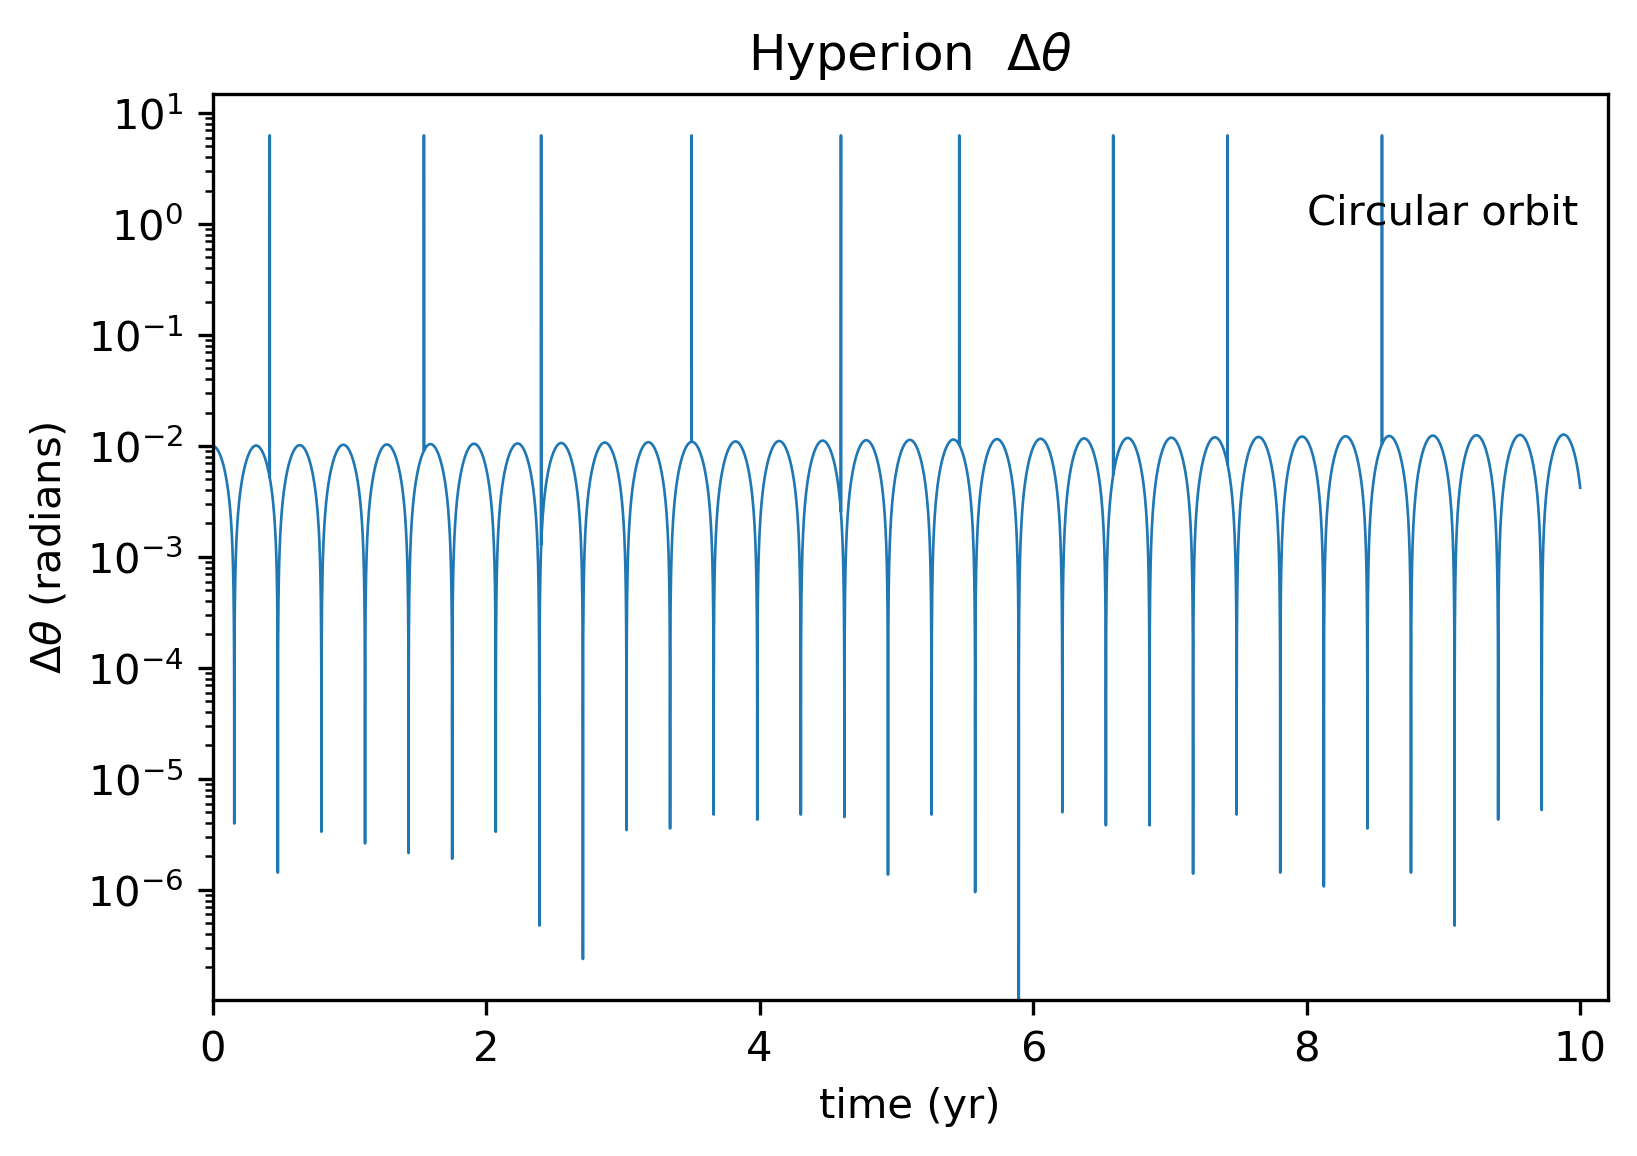

In [21]:
ax, fig = hyp_delta_theta_cir.compare_theta()
ax.text(8, 1, 'Circular orbit')
plt.show()

计算圆轨道的李雅普诺夫指数

In [22]:
w = np.polyfit(hyp_delta_theta_cir.t[1:], np.log(hyp_delta_theta_cir.delta_theta[1:]), 1)
p = np.poly1d(w)

lyapu_exp = p[1]
print('Lyapunov exponent:', lyapu_exp)

Lyapunov exponent: nan


d:\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


数值溢出, 但可以看出此处李雅普诺夫指数是一个很小的正数

## 椭圆轨道

In [23]:
hyp_delta_theta_ellip = Hyperion()
hyp_delta_theta_ellip.calc((1, 0), (0, 5), [0, 0.01], 0, 10)

(<matplotlib.axes._subplots.AxesSubplot at 0x1e39150f508>,
 <Figure size 1800x1200 with 1 Axes>)

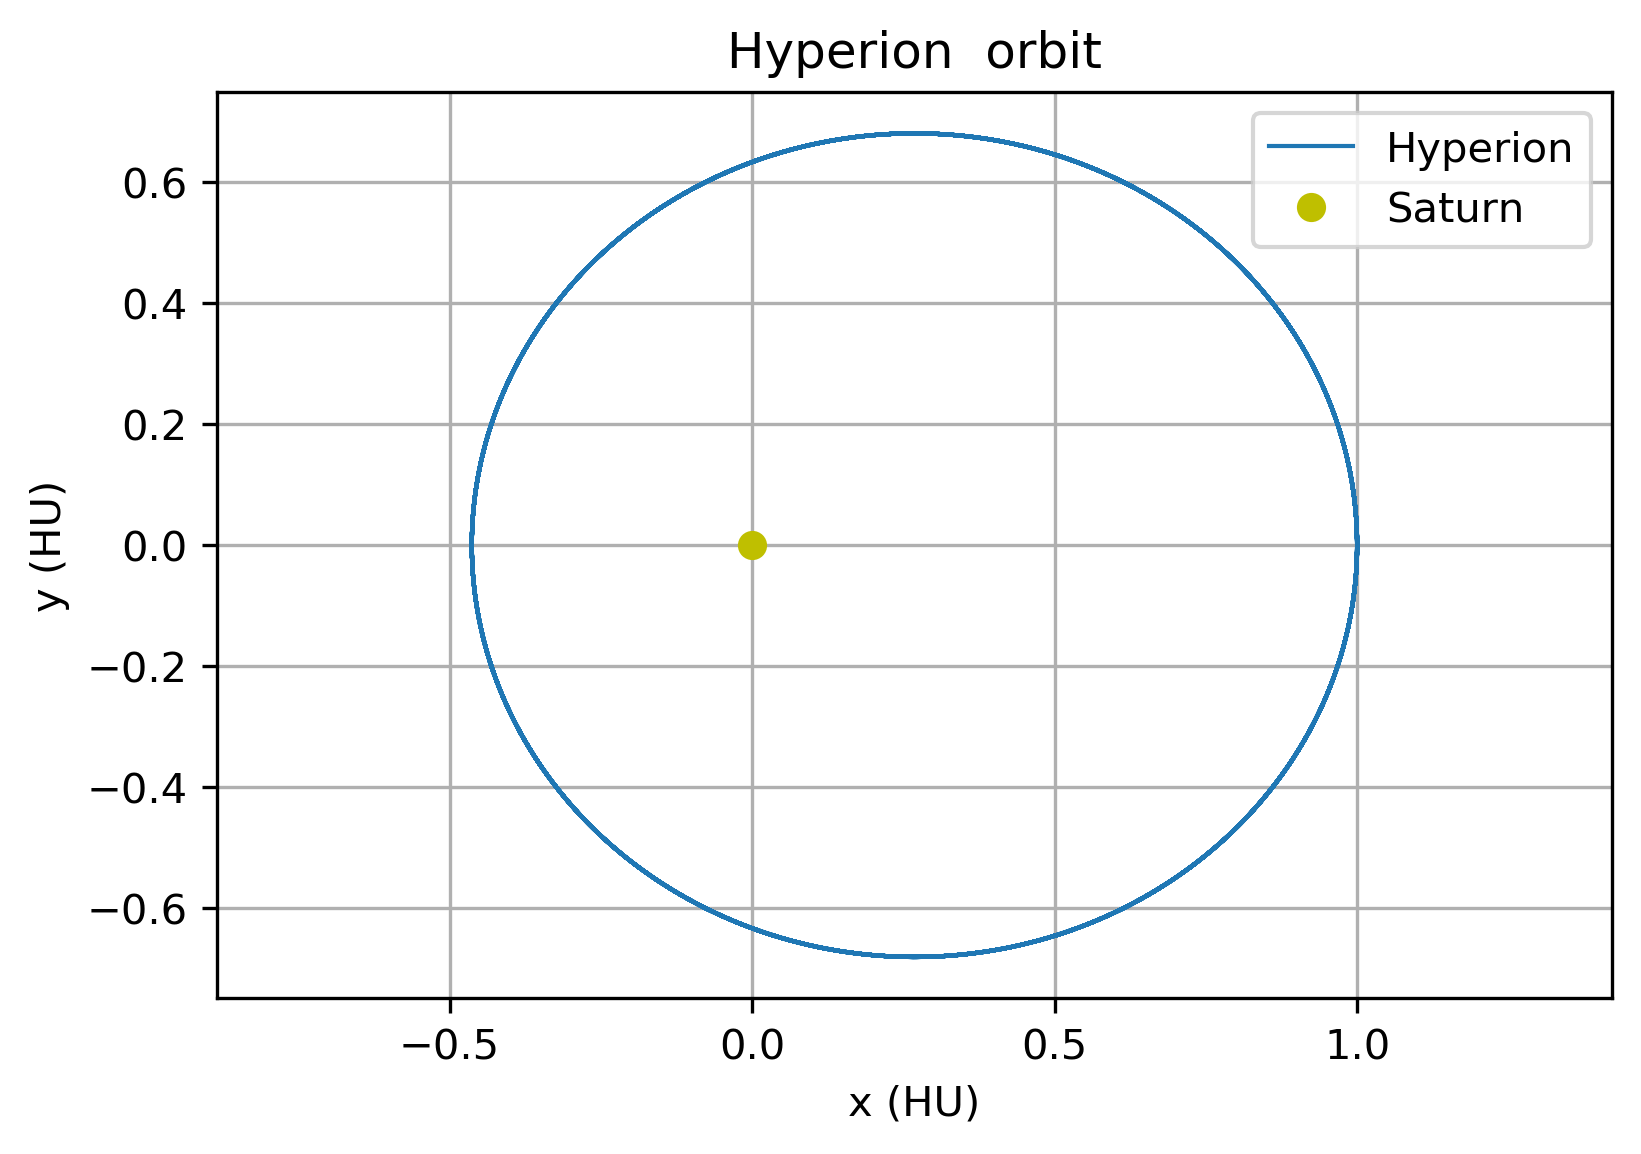

In [24]:
hyp_delta_theta_ellip.plot_orbit()

In [31]:
print('Orbit eccentricity:', Ex4_17.calc_eccentricity(hyp_delta_theta_ellip.xy[:, 0], hyp_delta_theta_ellip.xy[:, 1]))

Orbit eccentricity: 0.7327504077039662


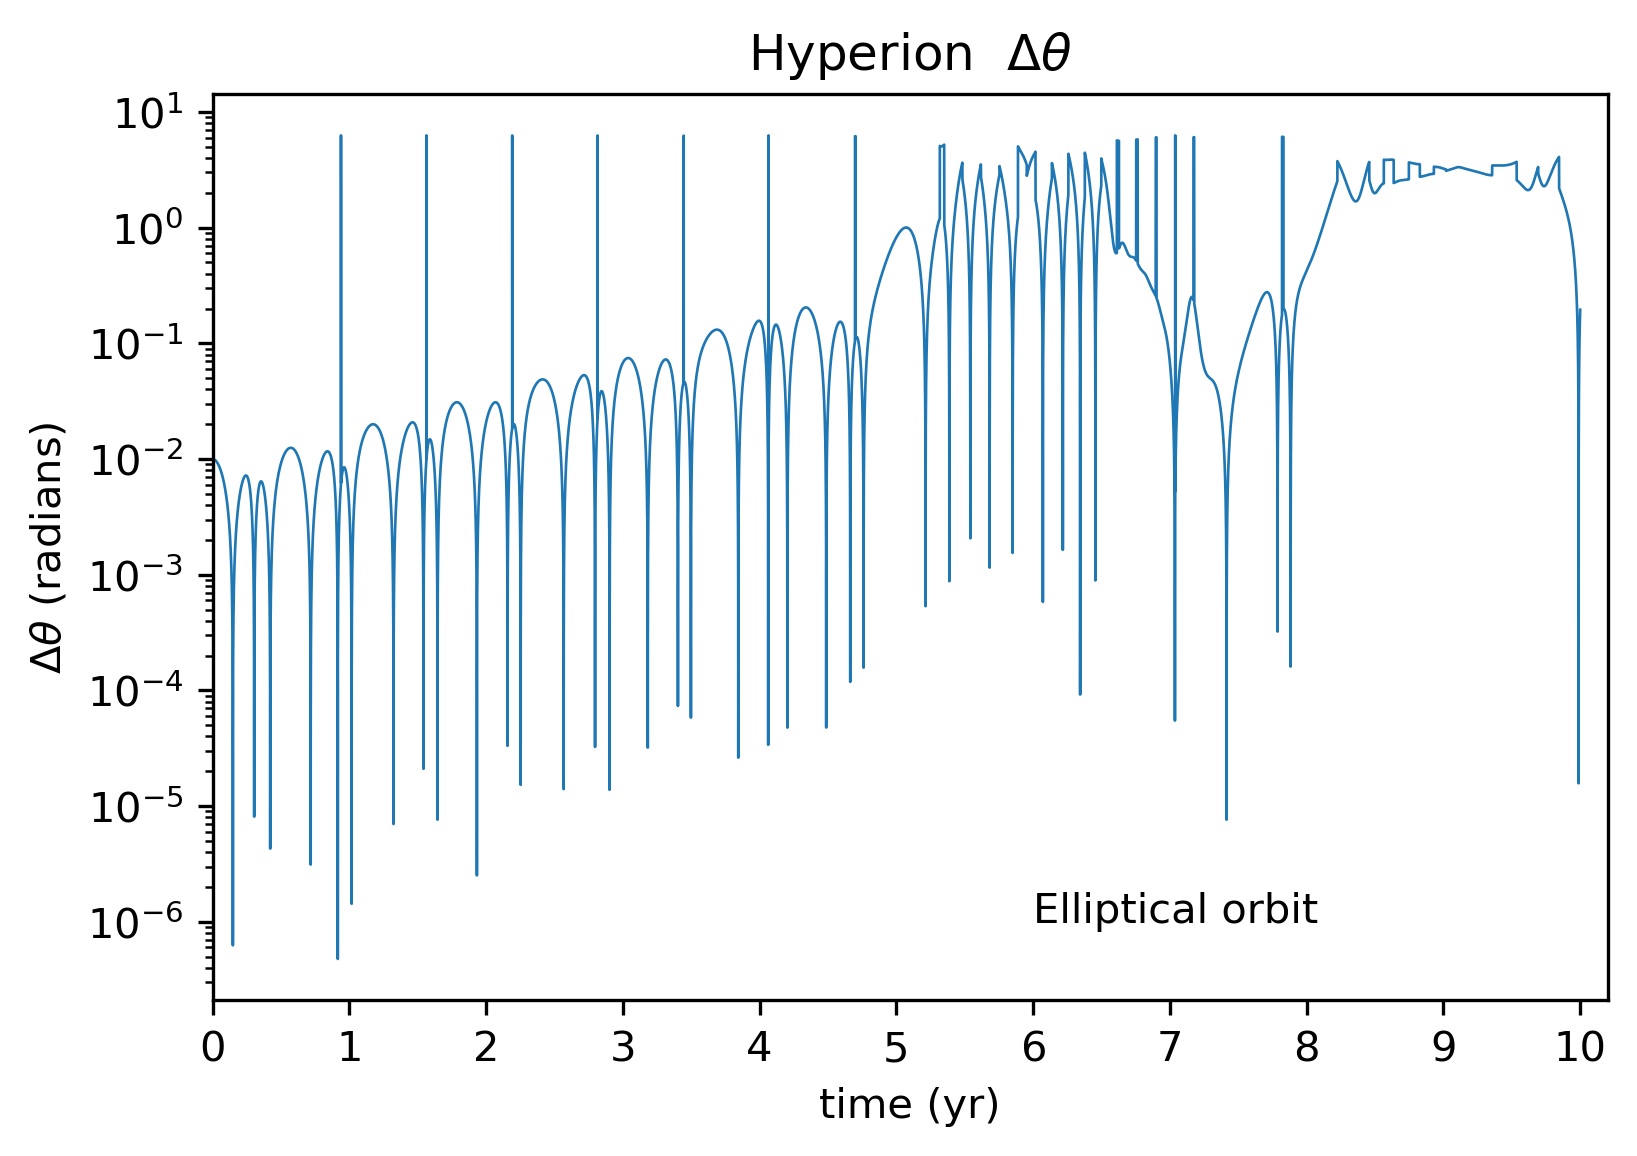

In [25]:
ax, fig = hyp_delta_theta_ellip.compare_theta()
ax.set_xticks(list(range(0, 11)))
ax.text(6, 1e-6, 'Elliptical orbit')
plt.show()

计算李雅普诺夫指数

In [26]:
ind = np.less_equal(hyp_delta_theta_ellip.t, 5)
delta_theta = hyp_delta_theta_ellip.delta_theta[ind]

In [44]:
def calc_lyapunov_exponent(t, delta):
    '''calculate the Lyapunov exponent given t and Delta
    '''
    w = np.polyfit(t, np.log(delta), 1)
    p = np.poly1d(w)

    return p[1]

In [28]:
print('Lyapunov exponent:', calc_lyapunov_exponent(np.array(hyp_delta_theta_ellip.t)[ind] ,delta_theta))

Lyapunov exponent: 0.7764223737669076


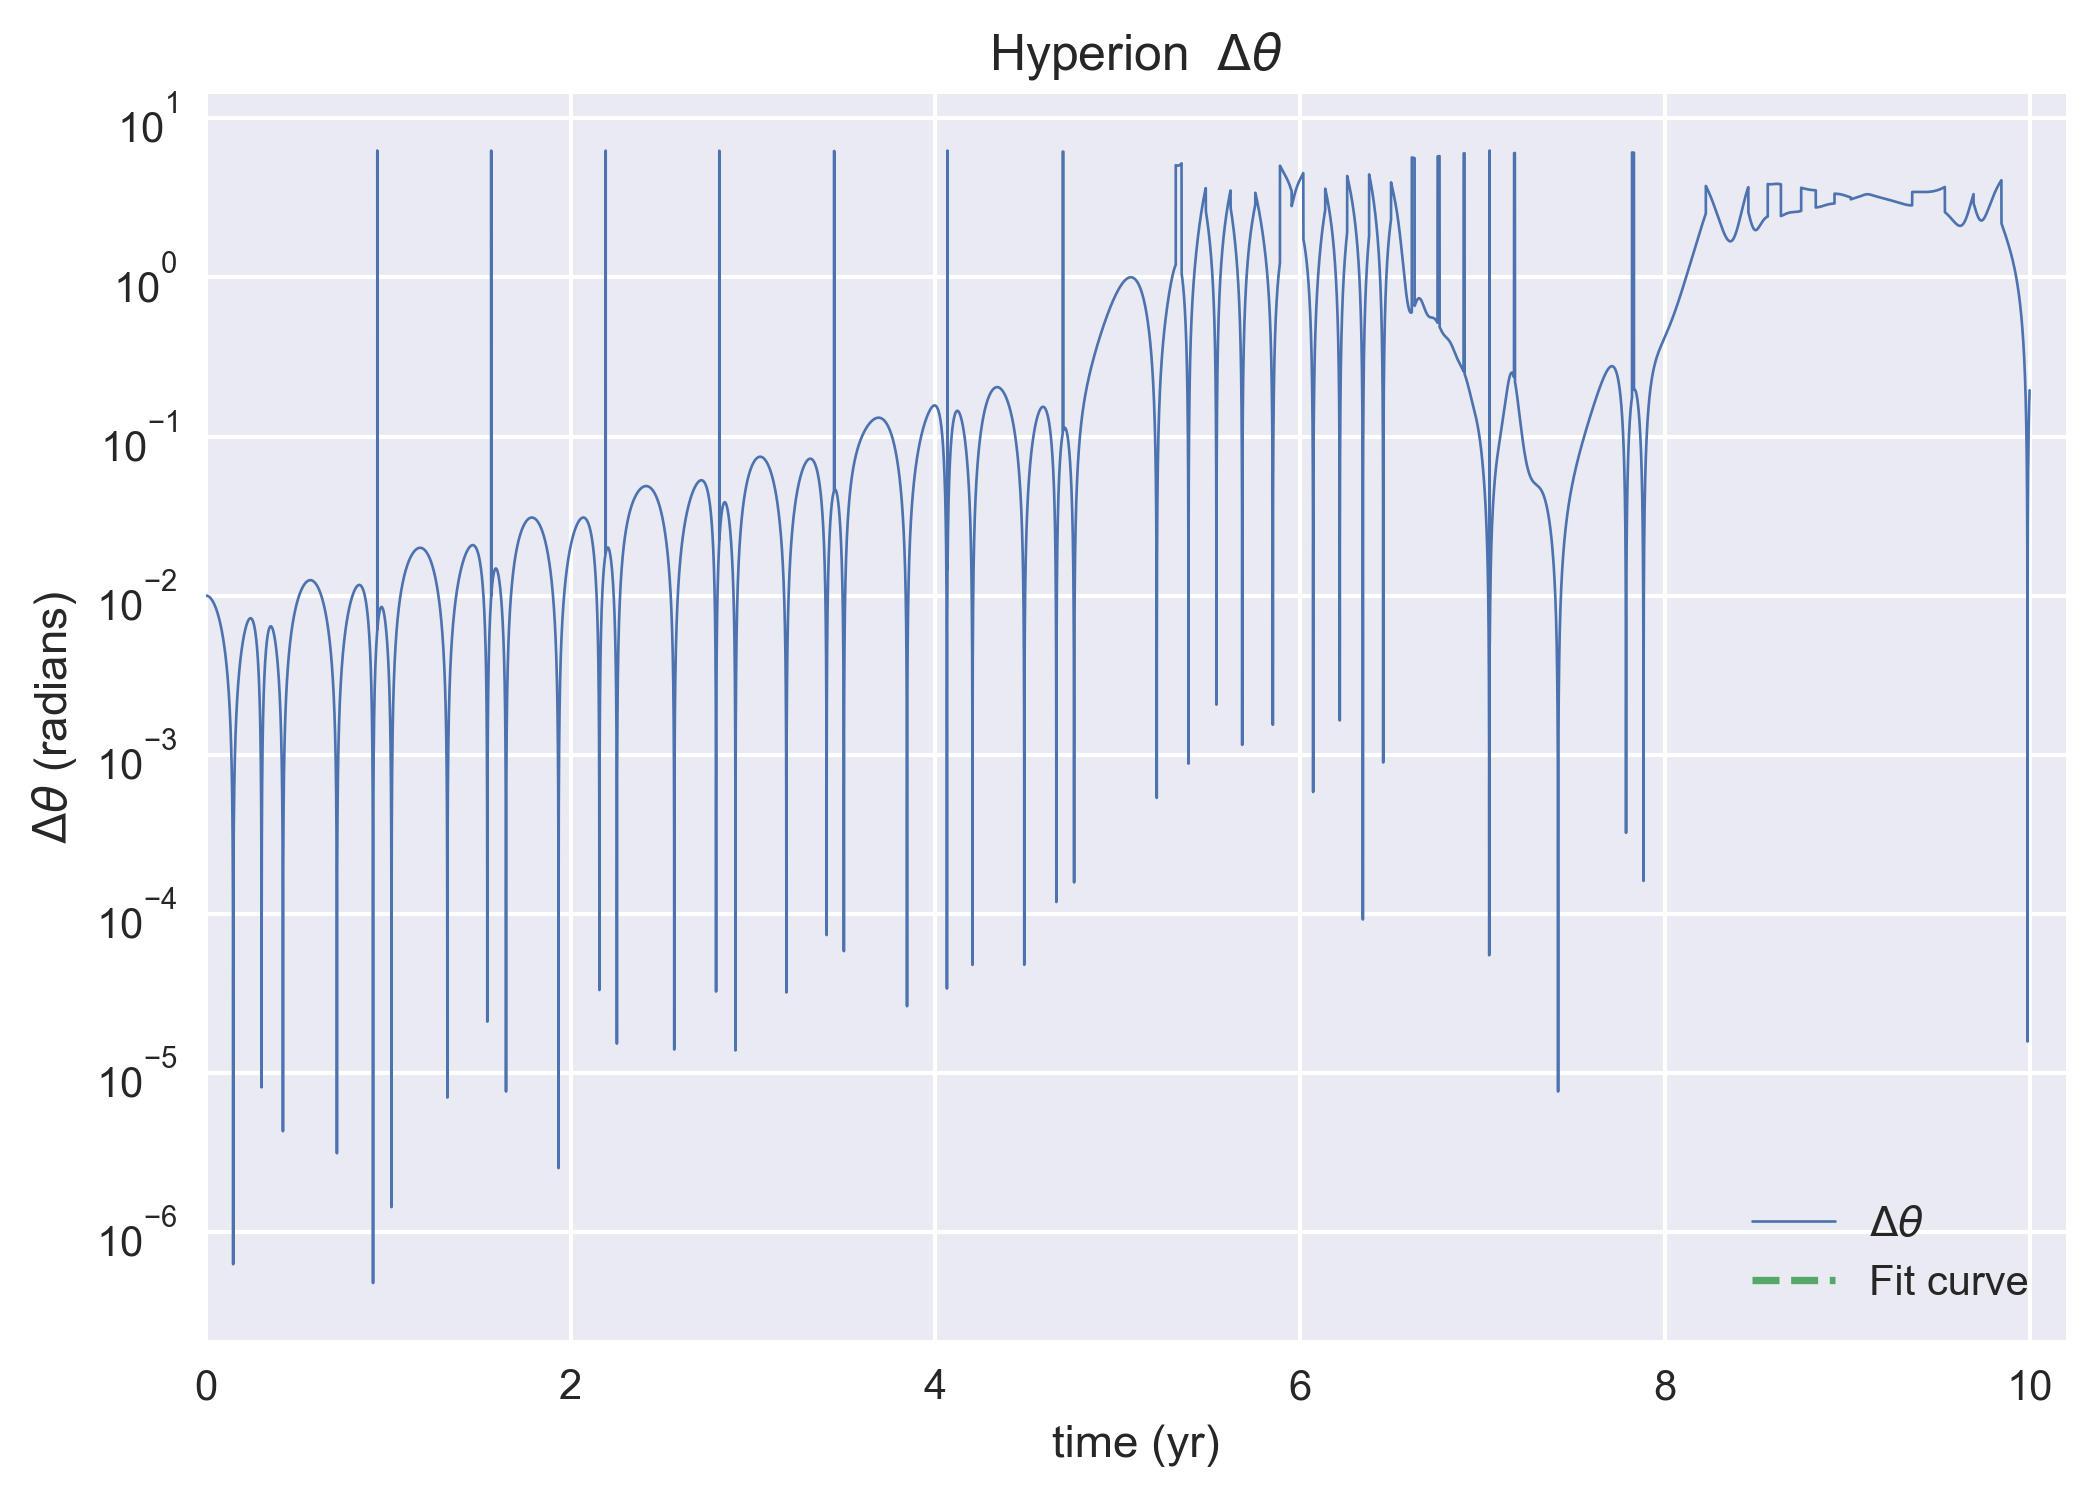

In [29]:
plt.style.use('seaborn')
ax, fig = hyp_delta_theta_ellip.compare_theta()
t = np.linspace(0, 5, 200)
y = p(t)
ax.plot(t, np.exp(y), '--')
ax.legend([r'$\Delta\theta$', 'Fit curve'])
plt.show()

对于椭圆轨道, 李雅普诺夫指数 $\lambda = 0.776 \gt 0$, 表明这是一个混沌现象

## 探究李雅普诺夫指数和轨道离心率的关系

首先确定不同初速度对应的 Δθ 到达最大值的时间, 在此时间之前的 Δθ 值才会被拿来算李雅普诺夫指数

这里还是用了拟合, 认为 Δθ 到达最大值的时间和初速度成指数关系

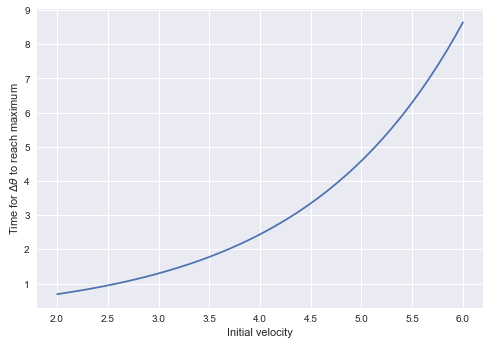

In [48]:
wt = np.polyfit([2, 3.5, 5], np.log([0.75, 1.5, 5]), 1)
pt = np.poly1d(wt)

plt.plot(np.linspace(2, 6), np.exp(pt(np.linspace(2, 6))))
plt.xlabel("Initial velocity")
plt.ylabel(r"Time for $\Delta \theta$ to reach maximum")
plt.show()

从曲线来看这个结果还还是可用的

In [45]:
hyp = Hyperion()
eccen = []
lyapu_exp = []
for v0 in np.arange(2, 2*np.pi, 0.1):
    time_to_max = np.exp(pt(v0))
    hyp.calc((1, 0), (0, v0), [0, 0.01], 0, time_to_max)
    hyp.compare_theta(plot=False)
    ax, fig = hyp.plot_orbit()
    ax.set_title('v0={:4g}'.format(v0))
    plt.show()
    eccen.append(Ex4_17.calc_eccentricity(hyp.xy[:,0], hyp.xy[:, 1]))
    ind = np.greater_equal(hyp.t, 0.1)
    lyapu_exp.append( calc_lyapunov_exponent(np.array(hyp.t)[ind], hyp.delta_theta[ind]) )

d:\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


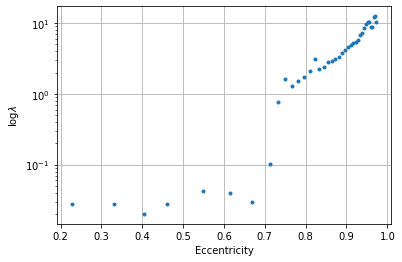

In [29]:
plt.plot(eccen, lyapu_exp, '.')
plt.xlabel('Eccentricity')
plt.ylabel(r'$\log \lambda$')
plt.yscale('log')
plt.grid(True)
plt.show()

从图像来看，可以用指数函数 $y = e^{kx+b}$ 来拟合结果

d:\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


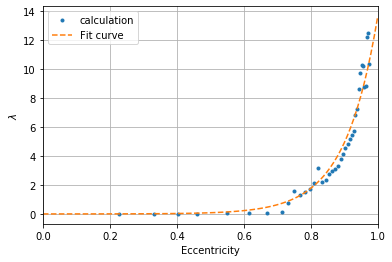

In [33]:
x = np.array(eccen)
y = np.array(lyapu_exp)

ind = np.logical_and(np.logical_not(np.isnan(y)), np.greater_equal(y, 0.7))
w2 = np.polyfit(x[ind], np.log(y[ind]), 1)
p2 = np.poly1d(w2)
pred = lambda x: np.exp(p2(x))

plt.plot(eccen, lyapu_exp, '.', label='calculation')
plt.plot(np.linspace(0, 1, 100), pred(np.linspace(0, 1, 100)), '--', label='Fit curve')
plt.xlim(0, 1)
plt.xlabel('Eccentricity')
plt.ylabel(r'$\lambda$')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

计算拟合结果的均方误差

In [34]:
y_pred = pred(x)
mse = np.sum((y_pred[ind] - y[ind]) ** 2) / len(y_pred)
print('Mean square error:', mse)

Mean square error: 0.654155311601379


均方误差较小，曲线较好地拟合了计算结果

用一个具体例子测试

In [35]:
hyp = Hyperion()

In [36]:
hyp.calc((1, 0), (0, 3.5), [0, 0.01], 0, 8)

In [39]:
e = Ex4_17.calc_eccentricity(hyp.xy[:,0], hyp.xy[:, 1])
print('Eccentricity:', e)

Eccentricity: 0.9035913071740431


In [45]:
ind = np.logical_and(np.greater_equal(hyp.t, 0.2), np.less_equal(hyp.t, 1.5))
l = calc_lyapunov_exponent(np.array(hyp.t)[ind], hyp.delta_theta[ind])
print('Lyapunov exponent, calculation:', l)
print('Lyapunov exponent, fit curve:', pred(e))

Lyapunov exponent, calculation: 5.605898161096491
Lyapunov exponent, fit curve: 5.101482930216701


在这个具体的例子中, 拟合结果和计算结果误差约为$0.9 \%$, 拟合结果和计算结果很接近